In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import collections
import os
from sklearn.model_selection import train_test_split
import boto3
from PIL import Image
import io 

2025-07-14 19:45:07.912516: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 19:45:07.928591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-14 19:45:07.953298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-14 19:45:07.953322: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 19:45:07.968933: I tensorflow/core/platform/cpu_feature_gua

In [10]:
class_to_idx = {
    "defect/door_panel": 0,
    "defect/missing_grab_handle": 1,
    "defect/off_lighting": 2,
    "non-defect": 3
}

In [11]:
bucket_name = 'sutd-mtd-images'
s3 = boto3.client('s3')

image_keys = []
labels = []

paginator = s3.get_paginator('list_objects_v2')
for page in paginator.paginate(Bucket=bucket_name):
    for obj in page.get('Contents', []):
        key = obj['Key']
        if key.lower().endswith(('.jpg', '.jpeg', '.png')):
            for prefix in class_to_idx:
                if key.startswith(prefix):
                    image_keys.append(key)
                    labels.append(class_to_idx[prefix])
                    break

In [12]:
def labeled_image_generator(bucket_name, keys, labels, target_size=(224, 224)):
    s3 = boto3.client('s3')
    for key, label in zip(keys, labels):
        try:
            response = s3.get_object(Bucket=bucket_name, Key=key)
            image_data = response['Body'].read()
            image = Image.open(io.BytesIO(image_data)).convert('RGB')
            image = image.resize(target_size)
            image_np = np.array(image).astype(np.float32) / 255.0
            yield image_np, label
        except Exception as e:
            print(f"Skipping {key}: {e}")

In [13]:
def create_dataset(keys, labels, batch_size=32):
    return tf.data.Dataset.from_generator(
        lambda: labeled_image_generator(bucket_name, keys, labels),
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32),
        )
    ).shuffle(512).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_keys, test_keys, train_labels, test_labels = train_test_split(
    image_keys, labels, test_size=0.2, stratify=labels, random_state=42
)

train_ds = create_dataset(train_keys, train_labels)
test_ds = create_dataset(test_keys, test_labels)

2025-07-14 19:51:29.108948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-14 19:51:29.158343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-14 19:51:29.163445: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

2025-07-14 19:52:20.548633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 140 of 512
2025-07-14 19:52:30.590993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 279 of 512
2025-07-14 19:52:47.100417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


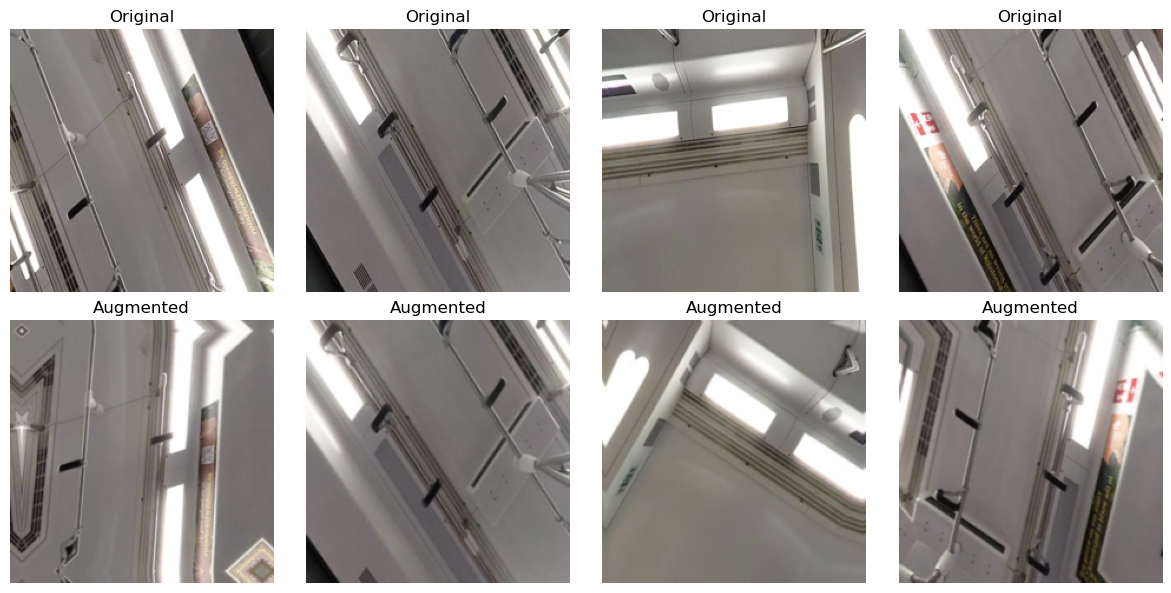

In [15]:
for images,_ in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    
    for i in range(4):
        original = (images[i].numpy() * 255).astype("uint8")
        
        augmented = (data_augmentation(tf.expand_dims(images[i], 0))[0].numpy() * 255).astype("uint8")
        
        plt.subplot(2, 4, i + 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2, 4, i + 5)
        plt.imshow(augmented)
        plt.title("Augmented")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    break

In [16]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
labels = []
for _, y in train_ds.unbatch():
    labels.append(int(y.numpy()))

print(collections.Counter(labels))

2025-07-14 19:54:05.019460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 174 of 512
2025-07-14 19:54:15.058684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 352 of 512
2025-07-14 19:54:23.695360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Counter({3: 4578, 2: 2330, 1: 1118, 0: 697})


2025-07-14 20:04:28.391807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
labels = []
for _, y in test_ds.unbatch():
    labels.append(int(y.numpy()))

print(collections.Counter(labels))

2025-07-14 20:04:38.466958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 136 of 512
2025-07-14 20:04:58.428135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 397 of 512
2025-07-14 20:05:07.641738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Counter({3: 1144, 2: 583, 1: 280, 0: 174})


2025-07-14 20:07:15.527449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
img_size = (224,224)

base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4, activation='softmax')  
])

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 2340228 (8.93 MB)
Trainable params: 8224

In [24]:
history = model.fit(train_ds, validation_data=test_ds, epochs=20)

Epoch 1/20


2025-07-14 20:09:50.017451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 140 of 512
2025-07-14 20:10:09.969426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 427 of 512
2025-07-14 20:10:16.062255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-07-14 20:10:18.541114: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1752523820.351063   13847 service.cc:145] XLA service 0x7feda87734c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752523820.351102   13847 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-07-14 20:10:20.357794: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_R

    273/Unknown - 645s 2s/step - loss: 0.7593 - accuracy: 0.6928

2025-07-14 20:20:04.673382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-14 20:20:04.673813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-07-14 20:20:19.401728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 145 of 512
2025-07-14 20:20:29.417872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 287 of 512
2025-07-14 20:20:39.418894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 425 of 512
2025-07-14 20:20:45.439045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer fi

273/273 [==============================] - 805s 3s/step - loss: 0.7593 - accuracy: 0.6928 - val_loss: 0.6658 - val_accuracy: 0.7066
Epoch 2/20


2025-07-14 20:22:44.485870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-14 20:22:44.486100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-07-14 20:22:54.724460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 154 of 512
2025-07-14 20:23:14.708675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 455 of 512
2025-07-14 20:23:18.411923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


272/273 [============================>.] - ETA: 2s - loss: 0.5290 - accuracy: 0.7812

2025-07-14 20:32:44.774679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 148 of 512
2025-07-14 20:33:04.740038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 444 of 512
2025-07-14 20:33:09.373438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 737s 3s/step - loss: 0.5286 - accuracy: 0.7815 - val_loss: 0.6358 - val_accuracy: 0.7478
Epoch 3/20


2025-07-14 20:35:11.273723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 158 of 512
2025-07-14 20:35:21.290252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 316 of 512
2025-07-14 20:35:33.477979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.8233

2025-07-14 20:44:27.538317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 159 of 512
2025-07-14 20:44:47.493412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 472 of 512
2025-07-14 20:44:50.015960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 696s 2s/step - loss: 0.4443 - accuracy: 0.8233 - val_loss: 0.4532 - val_accuracy: 0.8033
Epoch 4/20


2025-07-14 20:46:47.275832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 164 of 512
2025-07-14 20:46:57.297437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 330 of 512
2025-07-14 20:47:08.556903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


272/273 [============================>.] - ETA: 1s - loss: 0.4129 - accuracy: 0.8323

2025-07-14 20:55:43.003930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 164 of 512
2025-07-14 20:55:53.006293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 334 of 512
2025-07-14 20:56:03.028722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 506 of 512
2025-07-14 20:56:03.374039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 667s 2s/step - loss: 0.4127 - accuracy: 0.8322 - val_loss: 0.4385 - val_accuracy: 0.8111
Epoch 5/20


2025-07-14 20:57:53.912990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 165 of 512
2025-07-14 20:58:03.926704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 331 of 512
2025-07-14 20:58:14.746585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.8495

2025-07-14 21:06:56.991540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 165 of 512
2025-07-14 21:07:07.000023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 332 of 512
2025-07-14 21:07:17.785230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 679s 2s/step - loss: 0.3792 - accuracy: 0.8495 - val_loss: 0.4654 - val_accuracy: 0.8148
Epoch 6/20


2025-07-14 21:09:13.018747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 167 of 512
2025-07-14 21:09:33.002023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 497 of 512
2025-07-14 21:09:33.973278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


272/273 [============================>.] - ETA: 1s - loss: 0.3529 - accuracy: 0.8582

2025-07-14 21:18:21.025173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 158 of 512
2025-07-14 21:18:40.977725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 477 of 512
2025-07-14 21:18:43.093339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 685s 2s/step - loss: 0.3538 - accuracy: 0.8581 - val_loss: 0.4209 - val_accuracy: 0.8281
Epoch 7/20


2025-07-14 21:20:37.698997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 163 of 512
2025-07-14 21:20:47.718239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 322 of 512
2025-07-14 21:20:57.745331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 487 of 512
2025-07-14 21:20:59.296296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8586

2025-07-14 21:29:34.116816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 172 of 512
2025-07-14 21:29:44.140924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 341 of 512
2025-07-14 21:29:54.457960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 669s 2s/step - loss: 0.3426 - accuracy: 0.8586 - val_loss: 0.4078 - val_accuracy: 0.8336
Epoch 8/20


2025-07-14 21:31:46.308410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 163 of 512
2025-07-14 21:32:06.331354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 494 of 512
2025-07-14 21:32:07.453203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


272/273 [============================>.] - ETA: 1s - loss: 0.3336 - accuracy: 0.8679

2025-07-14 21:40:40.229391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 169 of 512
2025-07-14 21:40:50.232135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 340 of 512
2025-07-14 21:41:00.443822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 663s 2s/step - loss: 0.3337 - accuracy: 0.8677 - val_loss: 0.4693 - val_accuracy: 0.8203
Epoch 9/20


2025-07-14 21:42:49.504415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 165 of 512
2025-07-14 21:43:09.501691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 511 of 512
2025-07-14 21:43:09.557130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.8669

2025-07-14 21:51:23.503656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 174 of 512
2025-07-14 21:51:33.508897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 348 of 512
2025-07-14 21:51:42.956737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 641s 2s/step - loss: 0.3282 - accuracy: 0.8669 - val_loss: 0.4293 - val_accuracy: 0.8281
Epoch 10/20


2025-07-14 21:53:30.502720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 177 of 512
2025-07-14 21:53:40.527087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 347 of 512
2025-07-14 21:53:50.573326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


272/273 [============================>.] - ETA: 1s - loss: 0.3010 - accuracy: 0.8791

2025-07-14 22:02:05.405203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 172 of 512
2025-07-14 22:02:25.347922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 645s 2s/step - loss: 0.3009 - accuracy: 0.8792 - val_loss: 0.3824 - val_accuracy: 0.8391
Epoch 11/20


2025-07-14 22:04:15.194642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 166 of 512
2025-07-14 22:04:35.142846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 492 of 512
2025-07-14 22:04:36.359870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8747

2025-07-14 22:13:01.820790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 172 of 512
2025-07-14 22:13:21.833287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 655s 2s/step - loss: 0.3121 - accuracy: 0.8747 - val_loss: 0.4217 - val_accuracy: 0.8285
Epoch 12/20


2025-07-14 22:15:10.074662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 176 of 512
2025-07-14 22:15:29.342063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


272/273 [============================>.] - ETA: 1s - loss: 0.2984 - accuracy: 0.8773

2025-07-14 22:23:41.250202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 177 of 512
2025-07-14 22:24:00.598107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 636s 2s/step - loss: 0.2981 - accuracy: 0.8775 - val_loss: 0.3546 - val_accuracy: 0.8574
Epoch 13/20


2025-07-14 22:25:46.509218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 173 of 512
2025-07-14 22:25:56.532061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 342 of 512
2025-07-14 22:26:06.294070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8825

2025-07-14 22:34:16.308770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 176 of 512
2025-07-14 22:34:35.299448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 635s 2s/step - loss: 0.2892 - accuracy: 0.8825 - val_loss: 0.3661 - val_accuracy: 0.8450
Epoch 14/20


2025-07-14 22:36:21.513539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 179 of 512
2025-07-14 22:36:31.516949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 360 of 512
2025-07-14 22:36:40.022429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.2880 - accuracy: 0.8848

2025-07-14 22:44:38.520837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 177 of 512
2025-07-14 22:44:48.524617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 348 of 512
2025-07-14 22:44:57.799309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 621s 2s/step - loss: 0.2880 - accuracy: 0.8848 - val_loss: 0.3875 - val_accuracy: 0.8414
Epoch 15/20


2025-07-14 22:46:43.083914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 168 of 512
2025-07-14 22:46:53.096178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 334 of 512
2025-07-14 22:47:03.419940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


272/273 [============================>.] - ETA: 1s - loss: 0.2796 - accuracy: 0.8852

2025-07-14 22:55:03.315366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 175 of 512
2025-07-14 22:55:22.188804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 623s 2s/step - loss: 0.2797 - accuracy: 0.8852 - val_loss: 0.3504 - val_accuracy: 0.8519
Epoch 16/20


2025-07-14 22:57:06.458900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 178 of 512
2025-07-14 22:57:24.586650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


272/273 [============================>.] - ETA: 1s - loss: 0.2667 - accuracy: 0.8909

2025-07-14 23:05:27.639427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 170 of 512
2025-07-14 23:05:37.640671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 337 of 512
2025-07-14 23:05:47.654531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 501 of 512
2025-07-14 23:05:48.306534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 632s 2s/step - loss: 0.2665 - accuracy: 0.8910 - val_loss: 0.3538 - val_accuracy: 0.8647
Epoch 17/20


2025-07-14 23:07:38.088836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 168 of 512
2025-07-14 23:07:58.045737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 508 of 512
2025-07-14 23:07:58.275665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


272/273 [============================>.] - ETA: 1s - loss: 0.2615 - accuracy: 0.8971

2025-07-14 23:16:13.439225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 168 of 512
2025-07-14 23:16:23.447072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 338 of 512
2025-07-14 23:16:33.660510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 642s 2s/step - loss: 0.2619 - accuracy: 0.8971 - val_loss: 0.3850 - val_accuracy: 0.8579
Epoch 18/20


2025-07-14 23:18:20.450492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 172 of 512
2025-07-14 23:18:39.691280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.8881

2025-07-14 23:26:49.538321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 171 of 512
2025-07-14 23:27:08.719885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 634s 2s/step - loss: 0.2650 - accuracy: 0.8881 - val_loss: 0.3472 - val_accuracy: 0.8602
Epoch 19/20


2025-07-14 23:28:54.267676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 176 of 512
2025-07-14 23:29:04.279288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 356 of 512
2025-07-14 23:29:12.998808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


272/273 [============================>.] - ETA: 1s - loss: 0.2562 - accuracy: 0.8966

2025-07-14 23:37:15.424927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 179 of 512
2025-07-14 23:37:34.169900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 625s 2s/step - loss: 0.2564 - accuracy: 0.8965 - val_loss: 0.3876 - val_accuracy: 0.8459
Epoch 20/20


2025-07-14 23:39:18.900904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 174 of 512
2025-07-14 23:39:37.840932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9027

2025-07-14 23:47:33.136760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 179 of 512
2025-07-14 23:47:43.167974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 359 of 512
2025-07-14 23:47:51.934018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 618s 2s/step - loss: 0.2433 - accuracy: 0.9027 - val_loss: 0.4185 - val_accuracy: 0.8533


In [25]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

2025-07-14 23:49:37.037452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 201 of 512
2025-07-14 23:49:52.458501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1/1 [==============================] - 4s 4s/step


2025-07-14 23:51:22.290796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
cm = confusion_matrix(y_true, y_pred)
class_names = ['no_defect', 'grab_handle', 'door_panel', 'off_lighting'] 

In [27]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   no_defect       0.97      0.68      0.80       174
 grab_handle       0.91      0.46      0.61       280
  door_panel       0.87      0.94      0.90       583
off_lighting       0.83      0.93      0.88      1144

    accuracy                           0.85      2181
   macro avg       0.89      0.75      0.80      2181
weighted avg       0.86      0.85      0.84      2181



In [28]:
cm

array([[ 118,    0,    5,   51],
       [   0,  130,   13,  137],
       [   0,    0,  547,   36],
       [   4,   13,   61, 1066]])

In [29]:
model.save("Single_Model.h5")  

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
modelhalf = load_model("Single_Model.h5")

In [36]:
base_model.trainable = True

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         
    patience=2,         
    verbose=1
)

In [ ]:
model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=35,       
    initial_epoch=20,
    callbacks=[lr_schedule]
)

Epoch 21/35


2025-07-15 01:24:18.314347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 162 of 512
2025-07-15 01:24:38.280490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 480 of 512
2025-07-15 01:24:40.209483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


    273/Unknown - 589s 2s/step - loss: 0.4602 - accuracy: 0.8316

2025-07-15 01:33:37.901594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-15 01:33:37.902328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-07-15 01:33:52.588664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 152 of 512
2025-07-15 01:34:12.610332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 454 of 512
2025-07-15 01:34:16.394209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 738s 2s/step - loss: 0.4602 - accuracy: 0.8316 - val_loss: 14.0991 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 22/35


2025-07-15 01:36:06.714134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-15 01:36:06.714504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-07-15 01:36:16.954488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 159 of 512
2025-07-15 01:36:36.939729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 471 of 512
2025-07-15 01:36:39.498278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8819

2025-07-15 01:45:40.644113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 152 of 512
2025-07-15 01:45:50.663882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 302 of 512
2025-07-15 01:46:04.032066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 706s 2s/step - loss: 0.2995 - accuracy: 0.8819 - val_loss: 12.0386 - val_accuracy: 0.1229 - lr: 0.0010
Epoch 23/35


2025-07-15 01:48:02.882859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 158 of 512
2025-07-15 01:48:12.922790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 317 of 512
2025-07-15 01:48:22.934816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 470 of 512
2025-07-15 01:48:25.524394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9129

2025-07-15 01:57:16.554094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 157 of 512
2025-07-15 01:57:36.502847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 479 of 512
2025-07-15 01:57:38.483617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 691s 2s/step - loss: 0.2288 - accuracy: 0.9129 - val_loss: 6.7383 - val_accuracy: 0.3874 - lr: 0.0010
Epoch 24/35


2025-07-15 01:59:33.524017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 157 of 512
2025-07-15 01:59:53.551375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 485 of 512
2025-07-15 01:59:55.146647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.9363

2025-07-15 02:09:12.652669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 155 of 512
2025-07-15 02:09:22.661405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 305 of 512
2025-07-15 02:09:32.699531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 459 of 512
2025-07-15 02:09:36.442956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 727s 3s/step - loss: 0.1784 - accuracy: 0.9363 - val_loss: 27.9464 - val_accuracy: 0.1050 - lr: 0.0010
Epoch 25/35


2025-07-15 02:11:40.272215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 150 of 512
2025-07-15 02:11:50.301988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 298 of 512
2025-07-15 02:12:04.955624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9557

2025-07-15 02:21:37.507616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 150 of 512
2025-07-15 02:21:57.473817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 454 of 512
2025-07-15 02:22:01.405946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
273/273 [==============================] - 747s 3s/step - loss: 0.1316 - accuracy: 0.9557 - val_loss: 9.7033 - val_accuracy: 0.3232 - lr: 0.0010
Epoch 26/35


2025-07-15 02:24:07.122684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 148 of 512
2025-07-15 02:24:17.133113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 302 of 512
2025-07-15 02:24:27.146067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 452 of 512
2025-07-15 02:24:30.985803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9783

2025-07-15 02:33:37.523905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 159 of 512
2025-07-15 02:33:57.512516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 475 of 512
2025-07-15 02:33:59.864542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 711s 2s/step - loss: 0.0676 - accuracy: 0.9783 - val_loss: 7.2563 - val_accuracy: 0.3122 - lr: 5.0000e-04
Epoch 27/35


2025-07-15 02:35:57.815489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 153 of 512
2025-07-15 02:36:07.821578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 309 of 512
2025-07-15 02:36:20.908025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9939

2025-07-15 03:08:42.964095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 147 of 512
2025-07-15 03:08:52.991919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 296 of 512
2025-07-15 03:09:02.999696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 442 of 512
2025-07-15 03:09:07.546121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
273/273 [==============================] - 724s 3s/step - loss: 0.0209 - accuracy: 0.9939 - val_loss: 17.4500 - val_accuracy: 0.1476 - lr: 2.5000e-04
Epoch 30/35


2025-07-15 03:11:10.183190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 146 of 512
2025-07-15 03:11:30.170526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 427 of 512
2025-07-15 03:11:35.902550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9944

2025-07-15 03:20:51.143293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 155 of 512
2025-07-15 03:21:11.150444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 460 of 512
2025-07-15 03:21:14.317404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 723s 3s/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 10.4091 - val_accuracy: 0.1907 - lr: 1.2500e-04
Epoch 31/35


2025-07-15 03:23:13.735582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 154 of 512
2025-07-15 03:23:33.680192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 458 of 512
2025-07-15 03:23:37.486513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9952

2025-07-15 03:32:42.180182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 155 of 512
2025-07-15 03:32:52.191162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 306 of 512
2025-07-15 03:33:05.625071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 708s 2s/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 3.8208 - val_accuracy: 0.4370 - lr: 1.2500e-04
Epoch 32/35


2025-07-15 03:35:02.219540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 154 of 512
2025-07-15 03:35:22.218197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 467 of 512
2025-07-15 03:35:25.129735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9961

2025-07-15 03:44:30.079137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 157 of 512
2025-07-15 03:44:40.116047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 317 of 512
2025-07-15 03:44:52.499177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 708s 2s/step - loss: 0.0123 - accuracy: 0.9961 - val_loss: 3.2463 - val_accuracy: 0.4663 - lr: 1.2500e-04
Epoch 33/35


2025-07-15 03:46:49.989162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 154 of 512
2025-07-15 03:46:59.992177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 310 of 512
2025-07-15 03:47:09.997483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 456 of 512
2025-07-15 03:47:13.528022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9947

2025-07-15 03:56:17.146183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 154 of 512
2025-07-15 03:56:27.158402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 304 of 512
2025-07-15 03:56:37.173488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 463 of 512
2025-07-15 03:56:40.381285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 708s 2s/step - loss: 0.0144 - accuracy: 0.9947 - val_loss: 1.6404 - val_accuracy: 0.6887 - lr: 1.2500e-04
Epoch 34/35


2025-07-15 03:58:38.495635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 159 of 512
2025-07-15 03:58:48.518799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 319 of 512
2025-07-15 03:59:00.696054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9959

2025-07-15 04:08:22.788023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 153 of 512
2025-07-15 04:08:42.782348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 462 of 512
2025-07-15 04:08:46.065411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


273/273 [==============================] - 729s 3s/step - loss: 0.0126 - accuracy: 0.9959 - val_loss: 0.1718 - val_accuracy: 0.9509 - lr: 1.2500e-04
Epoch 35/35


2025-07-15 04:10:47.112715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 149 of 512
2025-07-15 04:10:57.158426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 296 of 512
2025-07-15 04:11:11.765591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


126/273 [============>.................] - ETA: 5:17 - loss: 0.0102 - accuracy: 0.9973

In [40]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

2025-07-15 04:53:34.543000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 156 of 512
2025-07-15 04:53:44.571261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 310 of 512
2025-07-15 04:53:57.704336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1/1 [==============================] - 4s 4s/step


2025-07-15 04:55:56.204939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
cm = confusion_matrix(y_true, y_pred)
class_names = ['no_defect', 'grab_handle', 'door_panel', 'off_lighting'] 

In [42]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   no_defect       0.96      0.99      0.98       174
 grab_handle       0.97      0.99      0.98       280
  door_panel       1.00      1.00      1.00       583
off_lighting       1.00      0.99      0.99      1144

    accuracy                           0.99      2181
   macro avg       0.98      0.99      0.99      2181
weighted avg       0.99      0.99      0.99      2181



In [43]:
model.save("Single_Model_Full.h5")  

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
model = load_model("Single_Model_Full.h5")

In [45]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

augmented_test_ds = test_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [46]:
loss_aug, accuracy_aug = model.evaluate(augmented_test_ds)
print(f"Augmented Validation Accuracy: {accuracy_aug:.4f}, Loss: {loss_aug:.4f}")

2025-07-15 04:56:14.912902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 167 of 512
2025-07-15 04:56:24.919681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 330 of 512
2025-07-15 04:56:34.946101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 493 of 512
2025-07-15 04:56:36.171368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


69/69 [==============================] - 147s 2s/step - loss: 0.0191 - accuracy: 0.9931
Augmented Validation Accuracy: 0.9931, Loss: 0.0191


2025-07-15 04:58:27.173974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-15 04:58:27.174198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2025-07-15 04:58:37.457423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 154 of 512
2025-07-15 04:58:57.409883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 454 of 512
2025-07-15 04:59:01.244086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


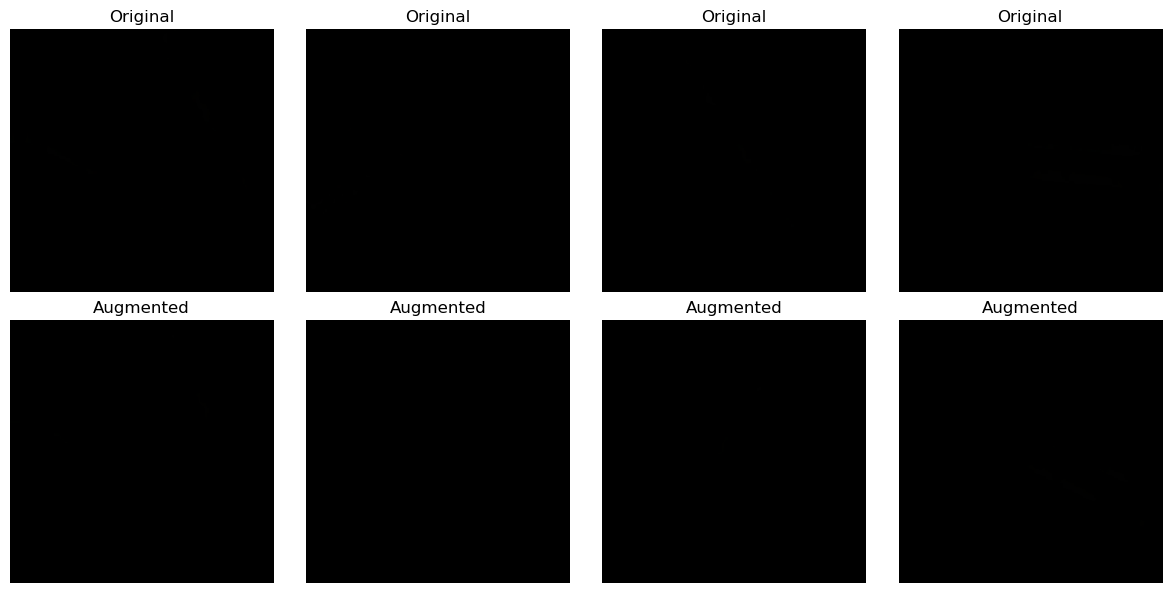

In [47]:
for images, _ in train_ds.take(1):
    plt.figure(figsize=(12, 6))
    
    for i in range(4):
        original = images[i].numpy().astype("uint8")
        augmented = data_augmentation(tf.expand_dims(images[i], 0))[0].numpy().astype("uint8")
        
        plt.subplot(2, 4, i + 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2, 4, i + 5)
        plt.imshow(augmented)
        plt.title("Augmented")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    break


In [48]:
halfmodel = load_model("Single_Model.h5")